In [5]:
import ast
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score

# ---------------------------
# Config
# ---------------------------
CSV_PATH = "wb_withpattern.pkl"
OUTPUT_DIR = "output"



SEED = 3111

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


def parse_wafer_map_field(field):
    """Parse waferMap field: could already be list/ndarray or a string repr."""
    if isinstance(field, str):
        try:
            arr = ast.literal_eval(field)
        except Exception:

            cleaned = field.replace("\\n", ",")
            try:
                arr = ast.literal_eval(cleaned)
            except Exception:

                nums = [int(s) for s in ''.join(ch if ch.isdigit() or ch in ' ,[]' else ' ' for ch in field).split()]
                arr = np.array(nums)
    else:
        arr = field
    arr = np.array(arr, dtype=np.uint8)

    if arr.ndim == 1:
        l = arr.size
        s = int(np.sqrt(l))
        if s*s == l:
            arr = arr.reshape(s, s)
    return arr


def parse_failure_type_field(field):
    """Robustly parse failureType field into a single label string.
    Examples of incoming formats:
      - '[[\'Loc\']]'
      - "['Loc']"
      - 'Loc'
      - [['Loc']]
    Return: cleaned string label (e.g. 'Loc')
    """
    # handle NaN
    if pd.isna(field):
        return 'Unknown'

    try:
        if not isinstance(field, str):

            def _flatten(x):
                if isinstance(x, (list, tuple, np.ndarray)) and len(x) > 0:
                    return _flatten(x[0])
                return x
            v = _flatten(field)
            return str(v)

        s = field.strip()

        try:
            val = ast.literal_eval(s)

            def _flatten_once(x):
                if isinstance(x, (list, tuple, np.ndarray)) and len(x) > 0:
                    return _flatten_once(x[0])
                return x
            v = _flatten_once(val)
            return str(v)
        except Exception:

            stripped = s

            while (stripped.startswith('[') and stripped.endswith(']')) or (stripped.startswith('(') and stripped.endswith(')')):
                stripped = stripped[1:-1].strip()

            if (stripped.startswith("\'") and stripped.endswith("\'") ) or (stripped.startswith('"') and stripped.endswith('"')):
                stripped = stripped[1:-1]

            cleaned = ''.join(ch for ch in stripped if ch.isalnum() or ch in ['_', '-', ' '])
            cleaned = cleaned.strip()
            if cleaned == '':
                return stripped
            return cleaned
    except Exception:
        return str(field)

# ---------------------------
# Dataset
# ---------------------------
class WaferDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = parse_wafer_map_field(row['waferMap'])  


        if img.max() <= 1:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)

        pil = Image.fromarray(img)
        pil = pil.convert('L')

        if self.transform:
            x = self.transform(pil)
        else:
            x = transforms.ToTensor()(pil)
            x = x.repeat(3, 1, 1)

        label = int(row['failureType'])
        return x, label

# ---------------------------
IMG_SIZE = 26 
# ---------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    #transforms.RandomRotation(30),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.repeat(3, 1, 1) if t.shape[0]==1 else t),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.repeat(3, 1, 1) if t.shape[0]==1 else t),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         #std=[0.229, 0.224, 0.225])
])


print("Loading pkl...", CSV_PATH)
df = pd.read_pickle(CSV_PATH)
if 'waferMap' not in df.columns:
    raise ValueError('must contain waferMap column')


if 'failureType' in df.columns:
    df['failureType_raw'] = df['failureType']
    df['failureType'] = df['failureType_raw'].apply(parse_failure_type_field)

    df['failureType'] = pd.Categorical(df['failureType']).codes
else:

    if 'trainTestLabel' in df.columns:
        df['failureType'] = pd.Categorical(df['trainTestLabel']).codes
    else:
        raise ValueError('No failureType or trainTestLabel column found')

num_classes = int(df['failureType'].nunique())
print(f"Num samples: {len(df)}, Num classes: {num_classes}")
print("Label distribution:\n", df['failureType'].value_counts().sort_index())

BATCH_SIZE=32
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['failureType'], random_state=SEED)

train_dataset = WaferDataset(train_df, transform=train_transform)
val_dataset = WaferDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False )

Loading pkl... wb_withpattern.pkl
Num samples: 25519, Num classes: 8
Label distribution:
 0    4294
1     555
2    5189
3    9680
4    3593
5     149
6     866
7    1193
Name: failureType, dtype: int64


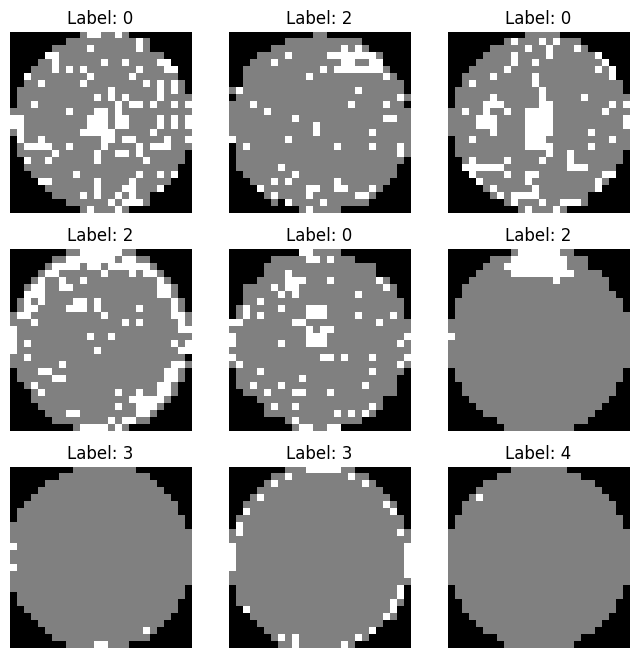

In [6]:
def show_images_gray(loader, n_images=9):
    loader_iter = iter(loader)
    images, labels = next(loader_iter)

    images = images[:n_images]
    labels = labels[:n_images]

    plt.figure(figsize=(8,8))
    for i in range(n_images):
        img = images[i]
        # 3채널이면 첫 채널만 사용
        if img.shape[0] == 3:
            img = img[0]
        plt.subplot(3, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

# 사용 예시
show_images_gray(train_loader, n_images=9)


In [7]:
class SimpleWaferCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        pooled = IMG_SIZE // 8
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * pooled * pooled, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", DEVICE)

Using: cuda


In [9]:

LEARNING_RATE = 1e-3
model_simple = SimpleWaferCNN(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_simple.parameters(), lr=LEARNING_RATE)


In [12]:
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report

NUM_EPOCHS = 40 

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n----- Epoch {epoch} 시작 -----")
    
    # ---- train ----
    model_simple.train()
    total_loss = 0
    total_correct = 0  
    total_samples = 0

    for xb, yb in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model_simple(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

        # Accuracy 계산
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == yb).sum().item()
        total_samples += xb.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    train_acc = total_correct / total_samples

    print(f"[{epoch}] loss={train_loss:.4f}, accuracy={train_acc:.4f}")
    print(f"----- Epoch {epoch} 종료 | loss={train_loss:.4f}, accuracy={train_acc:.4f} -----\n")



model_simple.eval()
ys_true, ys_pred = [], []

with torch.no_grad():
    for xb, yb in tqdm(val_loader, desc="Final Eval", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        preds = torch.argmax(model_simple(xb), dim=1)
        ys_true.append(yb.cpu().numpy())
        ys_pred.append(preds.cpu().numpy())

ys_true = np.concatenate(ys_true)
ys_pred = np.concatenate(ys_pred)

print("Final Validation Report:")
print(classification_report(ys_true, ys_pred, digits=4))



----- Epoch 1 시작 -----


Training Epoch 1: 100%|██████████| 638/638 [00:11<00:00, 54.59it/s]


[1] loss=0.0680, accuracy=0.9757
----- Epoch 1 종료 | loss=0.0680, accuracy=0.9757 -----


----- Epoch 2 시작 -----


Training Epoch 2: 100%|██████████| 638/638 [00:10<00:00, 58.72it/s]


[2] loss=0.0707, accuracy=0.9746
----- Epoch 2 종료 | loss=0.0707, accuracy=0.9746 -----


----- Epoch 3 시작 -----


Training Epoch 3: 100%|██████████| 638/638 [00:10<00:00, 59.78it/s]


[3] loss=0.0709, accuracy=0.9751
----- Epoch 3 종료 | loss=0.0709, accuracy=0.9751 -----


----- Epoch 4 시작 -----


Training Epoch 4: 100%|██████████| 638/638 [00:10<00:00, 59.62it/s]


[4] loss=0.0619, accuracy=0.9775
----- Epoch 4 종료 | loss=0.0619, accuracy=0.9775 -----


----- Epoch 5 시작 -----


Training Epoch 5: 100%|██████████| 638/638 [00:10<00:00, 59.56it/s]


[5] loss=0.0636, accuracy=0.9767
----- Epoch 5 종료 | loss=0.0636, accuracy=0.9767 -----


----- Epoch 6 시작 -----


Training Epoch 6: 100%|██████████| 638/638 [00:10<00:00, 59.76it/s]


[6] loss=0.0584, accuracy=0.9787
----- Epoch 6 종료 | loss=0.0584, accuracy=0.9787 -----


----- Epoch 7 시작 -----


Training Epoch 7: 100%|██████████| 638/638 [00:10<00:00, 59.44it/s]


[7] loss=0.0588, accuracy=0.9790
----- Epoch 7 종료 | loss=0.0588, accuracy=0.9790 -----


----- Epoch 8 시작 -----


Training Epoch 8: 100%|██████████| 638/638 [00:10<00:00, 59.80it/s]


[8] loss=0.0610, accuracy=0.9769
----- Epoch 8 종료 | loss=0.0610, accuracy=0.9769 -----


----- Epoch 9 시작 -----


Training Epoch 9: 100%|██████████| 638/638 [00:10<00:00, 59.88it/s]


[9] loss=0.0580, accuracy=0.9799
----- Epoch 9 종료 | loss=0.0580, accuracy=0.9799 -----


----- Epoch 10 시작 -----


Training Epoch 10: 100%|██████████| 638/638 [00:10<00:00, 59.55it/s]


[10] loss=0.0492, accuracy=0.9823
----- Epoch 10 종료 | loss=0.0492, accuracy=0.9823 -----


----- Epoch 11 시작 -----


Training Epoch 11: 100%|██████████| 638/638 [00:10<00:00, 59.72it/s]


[11] loss=0.0570, accuracy=0.9802
----- Epoch 11 종료 | loss=0.0570, accuracy=0.9802 -----


----- Epoch 12 시작 -----


Training Epoch 12: 100%|██████████| 638/638 [00:10<00:00, 59.32it/s]


[12] loss=0.0617, accuracy=0.9778
----- Epoch 12 종료 | loss=0.0617, accuracy=0.9778 -----


----- Epoch 13 시작 -----


Training Epoch 13: 100%|██████████| 638/638 [00:10<00:00, 60.18it/s]


[13] loss=0.0488, accuracy=0.9824
----- Epoch 13 종료 | loss=0.0488, accuracy=0.9824 -----


----- Epoch 14 시작 -----


Training Epoch 14: 100%|██████████| 638/638 [00:10<00:00, 60.53it/s]


[14] loss=0.0471, accuracy=0.9827
----- Epoch 14 종료 | loss=0.0471, accuracy=0.9827 -----


----- Epoch 15 시작 -----


Training Epoch 15: 100%|██████████| 638/638 [00:10<00:00, 59.61it/s]


[15] loss=0.0448, accuracy=0.9850
----- Epoch 15 종료 | loss=0.0448, accuracy=0.9850 -----


----- Epoch 16 시작 -----


Training Epoch 16: 100%|██████████| 638/638 [00:10<00:00, 59.71it/s]


[16] loss=0.0532, accuracy=0.9820
----- Epoch 16 종료 | loss=0.0532, accuracy=0.9820 -----


----- Epoch 17 시작 -----


Training Epoch 17: 100%|██████████| 638/638 [00:10<00:00, 59.77it/s]


[17] loss=0.0494, accuracy=0.9830
----- Epoch 17 종료 | loss=0.0494, accuracy=0.9830 -----


----- Epoch 18 시작 -----


Training Epoch 18: 100%|██████████| 638/638 [00:10<00:00, 58.21it/s]


[18] loss=0.0437, accuracy=0.9843
----- Epoch 18 종료 | loss=0.0437, accuracy=0.9843 -----


----- Epoch 19 시작 -----


Training Epoch 19: 100%|██████████| 638/638 [00:11<00:00, 55.19it/s]


[19] loss=0.0466, accuracy=0.9842
----- Epoch 19 종료 | loss=0.0466, accuracy=0.9842 -----


----- Epoch 20 시작 -----


Training Epoch 20: 100%|██████████| 638/638 [00:11<00:00, 54.51it/s]


[20] loss=0.0421, accuracy=0.9845
----- Epoch 20 종료 | loss=0.0421, accuracy=0.9845 -----


----- Epoch 21 시작 -----


Training Epoch 21: 100%|██████████| 638/638 [00:12<00:00, 50.16it/s]


[21] loss=0.0499, accuracy=0.9828
----- Epoch 21 종료 | loss=0.0499, accuracy=0.9828 -----


----- Epoch 22 시작 -----


Training Epoch 22: 100%|██████████| 638/638 [00:11<00:00, 57.85it/s]


[22] loss=0.0431, accuracy=0.9848
----- Epoch 22 종료 | loss=0.0431, accuracy=0.9848 -----


----- Epoch 23 시작 -----


Training Epoch 23: 100%|██████████| 638/638 [00:11<00:00, 55.81it/s]


[23] loss=0.0437, accuracy=0.9840
----- Epoch 23 종료 | loss=0.0437, accuracy=0.9840 -----


----- Epoch 24 시작 -----


Training Epoch 24: 100%|██████████| 638/638 [00:11<00:00, 57.84it/s]


[24] loss=0.0463, accuracy=0.9844
----- Epoch 24 종료 | loss=0.0463, accuracy=0.9844 -----


----- Epoch 25 시작 -----


Training Epoch 25: 100%|██████████| 638/638 [00:11<00:00, 57.33it/s]


[25] loss=0.0393, accuracy=0.9865
----- Epoch 25 종료 | loss=0.0393, accuracy=0.9865 -----


----- Epoch 26 시작 -----


Training Epoch 26: 100%|██████████| 638/638 [00:11<00:00, 55.78it/s]


[26] loss=0.0433, accuracy=0.9852
----- Epoch 26 종료 | loss=0.0433, accuracy=0.9852 -----


----- Epoch 27 시작 -----


Training Epoch 27: 100%|██████████| 638/638 [00:11<00:00, 56.30it/s]


[27] loss=0.0365, accuracy=0.9878
----- Epoch 27 종료 | loss=0.0365, accuracy=0.9878 -----


----- Epoch 28 시작 -----


Training Epoch 28: 100%|██████████| 638/638 [00:10<00:00, 58.79it/s]


[28] loss=0.0426, accuracy=0.9858
----- Epoch 28 종료 | loss=0.0426, accuracy=0.9858 -----


----- Epoch 29 시작 -----


Training Epoch 29: 100%|██████████| 638/638 [00:11<00:00, 57.30it/s]


[29] loss=0.0398, accuracy=0.9856
----- Epoch 29 종료 | loss=0.0398, accuracy=0.9856 -----


----- Epoch 30 시작 -----


Training Epoch 30: 100%|██████████| 638/638 [00:10<00:00, 61.44it/s]


[30] loss=0.0371, accuracy=0.9863
----- Epoch 30 종료 | loss=0.0371, accuracy=0.9863 -----


----- Epoch 31 시작 -----


Training Epoch 31: 100%|██████████| 638/638 [00:11<00:00, 56.39it/s]


[31] loss=0.0454, accuracy=0.9852
----- Epoch 31 종료 | loss=0.0454, accuracy=0.9852 -----


----- Epoch 32 시작 -----


Training Epoch 32: 100%|██████████| 638/638 [00:10<00:00, 60.78it/s]


[32] loss=0.0315, accuracy=0.9887
----- Epoch 32 종료 | loss=0.0315, accuracy=0.9887 -----


----- Epoch 33 시작 -----


Training Epoch 33: 100%|██████████| 638/638 [00:09<00:00, 65.33it/s]


[33] loss=0.0386, accuracy=0.9865
----- Epoch 33 종료 | loss=0.0386, accuracy=0.9865 -----


----- Epoch 34 시작 -----


Training Epoch 34: 100%|██████████| 638/638 [00:09<00:00, 65.68it/s]


[34] loss=0.0362, accuracy=0.9881
----- Epoch 34 종료 | loss=0.0362, accuracy=0.9881 -----


----- Epoch 35 시작 -----


Training Epoch 35: 100%|██████████| 638/638 [00:09<00:00, 65.59it/s]


[35] loss=0.0402, accuracy=0.9855
----- Epoch 35 종료 | loss=0.0402, accuracy=0.9855 -----


----- Epoch 36 시작 -----


Training Epoch 36: 100%|██████████| 638/638 [00:09<00:00, 65.56it/s]


[36] loss=0.0366, accuracy=0.9874
----- Epoch 36 종료 | loss=0.0366, accuracy=0.9874 -----


----- Epoch 37 시작 -----


Training Epoch 37: 100%|██████████| 638/638 [00:11<00:00, 54.25it/s]


[37] loss=0.0356, accuracy=0.9873
----- Epoch 37 종료 | loss=0.0356, accuracy=0.9873 -----


----- Epoch 38 시작 -----


Training Epoch 38: 100%|██████████| 638/638 [00:11<00:00, 55.35it/s]


[38] loss=0.0385, accuracy=0.9870
----- Epoch 38 종료 | loss=0.0385, accuracy=0.9870 -----


----- Epoch 39 시작 -----


Training Epoch 39: 100%|██████████| 638/638 [00:10<00:00, 61.71it/s]


[39] loss=0.0371, accuracy=0.9877
----- Epoch 39 종료 | loss=0.0371, accuracy=0.9877 -----


----- Epoch 40 시작 -----


Training Epoch 40: 100%|██████████| 638/638 [00:10<00:00, 60.70it/s]


[40] loss=0.0294, accuracy=0.9902
----- Epoch 40 종료 | loss=0.0294, accuracy=0.9902 -----



Final Validation Report:
              precision    recall  f1-score   support

           0     0.9477    0.9290    0.9383       859
           1     0.8468    0.8468    0.8468       111
           2     0.7855    0.8430    0.8132      1038
           3     0.9424    0.9716    0.9568      1936
           4     0.7184    0.7204    0.7194       719
           5     0.7632    0.9667    0.8529        30
           6     0.7475    0.8728    0.8053       173
           7     0.6125    0.2059    0.3082       238

    accuracy                         0.8611      5104
   macro avg     0.7955    0.7945    0.7801      5104
weighted avg     0.8547    0.8611    0.8526      5104



In [11]:
print("Final Validation Report:")
print(classification_report(ys_true, ys_pred, digits=4))

Final Validation Report:
              precision    recall  f1-score   support

           0     0.9337    0.8696    0.9005       859
           1     0.8526    0.7297    0.7864       111
           2     0.6007    0.8680    0.7100      1038
           3     0.9419    0.8884    0.9144      1936
           4     0.8287    0.3769    0.5182       719
           5     0.4915    0.9667    0.6517        30
           6     0.2561    0.7225    0.3782       173
           7     0.6667    0.0252    0.0486       238

    accuracy                         0.7602      5104
   macro avg     0.6965    0.6809    0.6135      5104
weighted avg     0.8145    0.7602    0.7518      5104

